In [51]:
#%load_ext jupyter_black

In [52]:
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from matplotlib import pyplot as plt
from pylab import rcParams
import sklearn
from sklearn.linear_model import LinearRegression
import talib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MaxAbsScaler
import time
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Conv2D, MaxPooling2D, Flatten, LSTM
from tensorflow.keras.metrics import *
import os
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
import optuna

In [53]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

<h1 style="font-size:40px;"> <center> FUNCTIONS </center> </h1>

In [54]:
SEED = 42


def set_random_seed():
    tf.keras.utils.set_random_seed(SEED)


def HMA(df: pd.DataFrame, timeperiod: int = 14) -> float:
    """
    Hull Moving Average.
    Formula:
    HMA = WMA(2*WMA(n/2) - WMA(n)), sqrt(n)
    """
    hma = talib.WMA(
        2 * talib.WMA(df, int(timeperiod / 2)) - talib.WMA(df, timeperiod),
        int(np.sqrt(timeperiod)),
    )
    return hma


def money_flow_volume_series(df: pd.DataFrame) -> pd.Series:
    """
    Calculates money flow series
    """
    mfv = (
        df["Volume"]
        * (2 * df["Close"] - df["High"] - df["Low"])
        / (df["High"] - df["Low"])
    )
    return mfv


def money_flow_volume(df: pd.DataFrame, timeperiod: int = 20) -> pd.Series:
    """
    Calculates money flow volume, or q_t in our formula
    """
    return money_flow_volume_series(df).rolling(timeperiod).sum()


def CMF(df: pd.DataFrame, timeperiod: int = 20) -> pd.Series:
    """
    Calculates the Chaikin money flow
    """
    return money_flow_volume(df, timeperiod) / df["Volume"].rolling(timeperiod).sum()


def pltcolor(lst: list) -> list:
    cols = []
    for i in range(lst.shape[0]):
        if lst.iloc[i] == 1:
            cols.append("green")
        elif lst.iloc[i] == 2:
            cols.append("red")
    return cols


def trendNormalizePrices(prices: pd.DataFrame) -> None:
    df = prices.copy()
    df["rowNumber"] = list(range(len(df)))
    df["TN_Open"] = list(range(len(df)))
    df["TN_High"] = list(range(len(df)))
    df["TN_Low"] = list(range(len(df)))
    df["TN_Close"] = list(range(len(df)))
    for i in range(29, len(df)):
        model = LinearRegression()
        model.fit(
            np.array(df["rowNumber"].iloc[i - 29 : i + 1]).reshape(-1, 1),
            np.array(df["Close"].iloc[i - 29 : i + 1]),
        )
        prediction = model.predict(np.array([df["rowNumber"].iloc[i]]).reshape(-1, 1))
        df.iloc[i, df.columns.get_loc("TN_Open")] = df["Open"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_High")] = df["High"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_Low")] = df["Low"].iloc[i] - prediction
        df.iloc[i, df.columns.get_loc("TN_Close")] = df["Close"].iloc[i] - prediction
    df["Open"] = df["TN_Open"]
    df["High"] = df["TN_High"]
    df["Low"] = df["TN_Low"]
    df["Close"] = df["TN_Close"]
    df = df.drop(index=df.index[:30], axis=0)
    df = df.drop(
        columns=["TN_Open", "TN_High", "TN_Low", "TN_Close", "rowNumber"], axis=1
    )
    return df


def create_labels(prices: pd.DataFrame) -> None:
    df = prices.copy()
    df["Label"] = [0] * df.shape[0]
    for i in range(df.shape[0] - 10):
        s = set(df["Close"].iloc[i : i + 11])
        minPrice = sorted(s)[0]
        maxPrice = sorted(s)[-1]
        for j in range(i, i + 11):
            if df["Close"].iloc[j] == minPrice and (j - i) == 5:
                df.iloc[j, df.columns.get_loc("Label")] = 1
            elif df["Close"].iloc[j] == maxPrice and (j - i) == 5:
                df.iloc[j, df.columns.get_loc("Label")] = 2
    return df.iloc[6:-6]


def reverse_one_hot(predictions: np.array) -> np.array:
    return np.argmax(predictions, axis=1)


def one_hot(predictions: np.array) -> np.array:
    predictions_one_hot = []
    for i in predictions:
        prediction = [0, 0, 0]
        prediction[int(i)] = 1
        predictions_one_hot.append(prediction)
    return np.array(predictions_one_hot)


def number_null_and_nan(df: pd.DataFrame) -> int:
    na = pd.isna(df).sum().sum()
    null = df.isnull().sum().sum()
    return na + null

<h1 style="font-size:40px;"> <center> DATA PREPROCESSING </center> </h1>

In [55]:
prices = yf.download(
    "SPY",
    start="2009-09-20",
    end="2023-01-01",
    interval="1d",
    progress=False,
    auto_adjust=True,
)
prices

,Open,High,Low,Close,Volume
Date,,,,,
2009-09-21 00:00:00-04:00,82.204689,83.066406,82.026138,82.639427,151892000
2009-09-22 00:00:00-04:00,83.128538,83.353672,82.755901,83.120773,143126700
2009-09-23 00:00:00-04:00,83.314846,83.866034,82.282337,82.429840,225947400
2009-09-24 00:00:00-04:00,82.608382,82.786932,81.164423,81.521530,228636800
2009-09-25 00:00:00-04:00,81.342964,81.793232,80.807301,81.086777,204059000
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,379.649994,383.059998,378.029999,382.910004,59857300
2022-12-27 00:00:00-05:00,382.790009,383.149994,379.649994,381.399994,51638200
2022-12-28 00:00:00-05:00,381.329987,383.390015,376.420013,376.660004,70911500


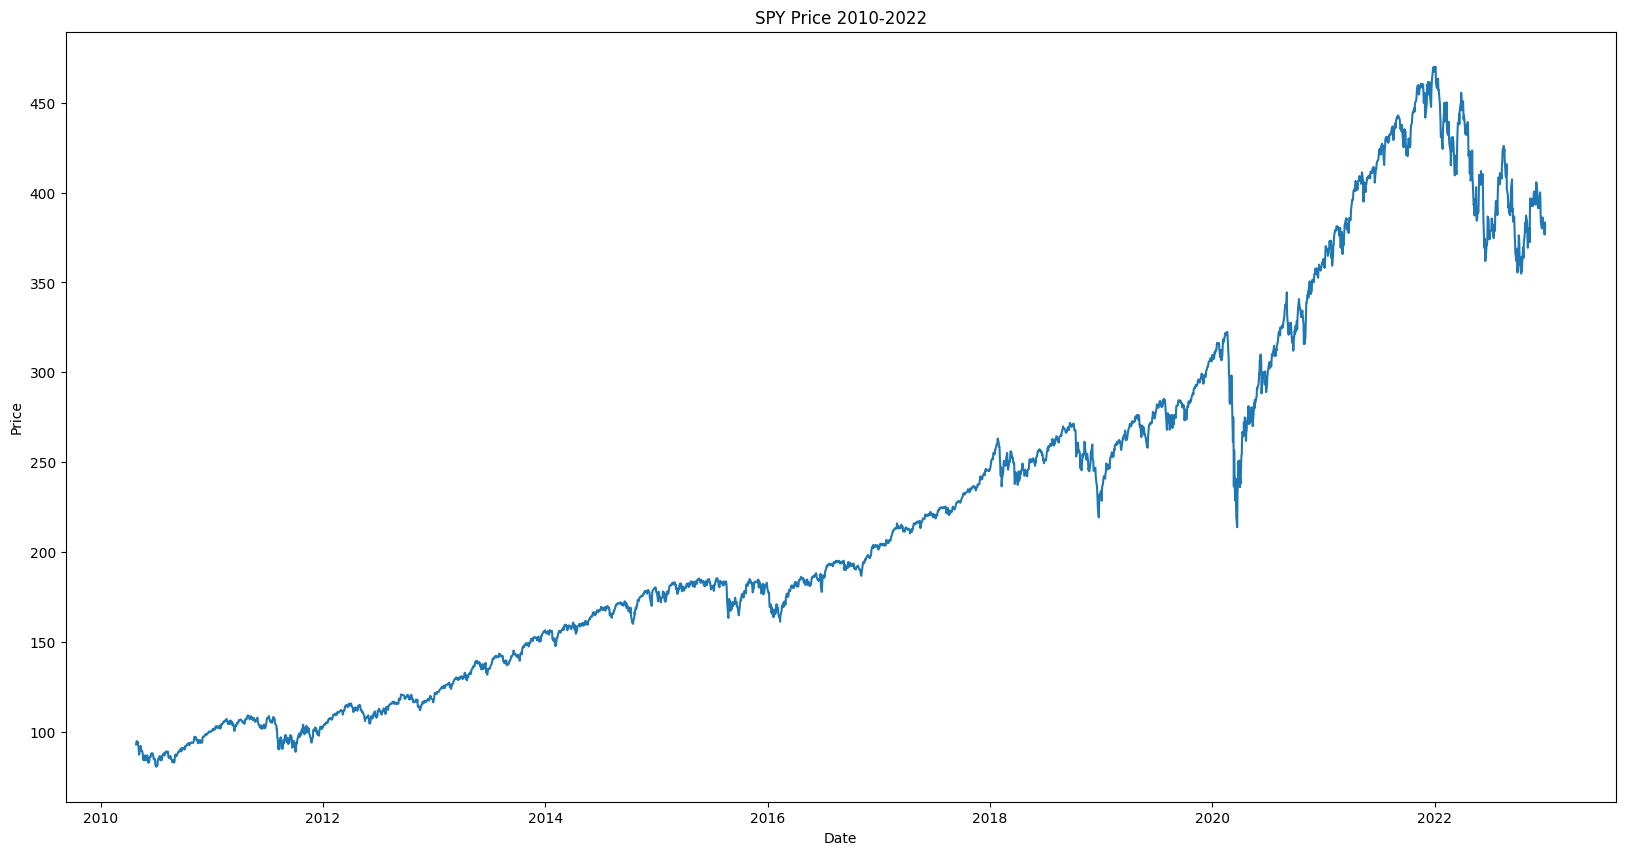

In [56]:
plt.figure(figsize=(20, 10))
plt.title("SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(prices[["Close"]].iloc[150:, :])

<h1 style="font-size:30px;"> <center> Trend Normalize and Visualize </center> </h1>

In [57]:
tn_prices = trendNormalizePrices(prices)
tn_prices

,Open,High,Low,Close,Volume
Date,,,,,
2009-11-02 00:00:00-05:00,-2.497216,-1.503520,-3.312350,-2.349713,254222900
2009-11-03 00:00:00-05:00,-2.646052,-1.823147,-2.801314,-1.939597,228362600
2009-11-04 00:00:00-05:00,-1.110672,-0.474089,-1.778310,-1.568705,247996700
2009-11-05 00:00:00-05:00,-0.968802,-0.021694,-1.139594,-0.044983,180015300
2009-11-06 00:00:00-05:00,-0.467002,0.418004,-0.630029,0.208394,170954100
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,-7.306054,-3.896050,-8.926049,-4.046044,59857300
2022-12-27 00:00:00-05:00,-2.835277,-2.475292,-5.975292,-4.225292,51638200
2022-12-28 00:00:00-05:00,-2.236787,-0.176759,-7.146761,-6.906770,70911500


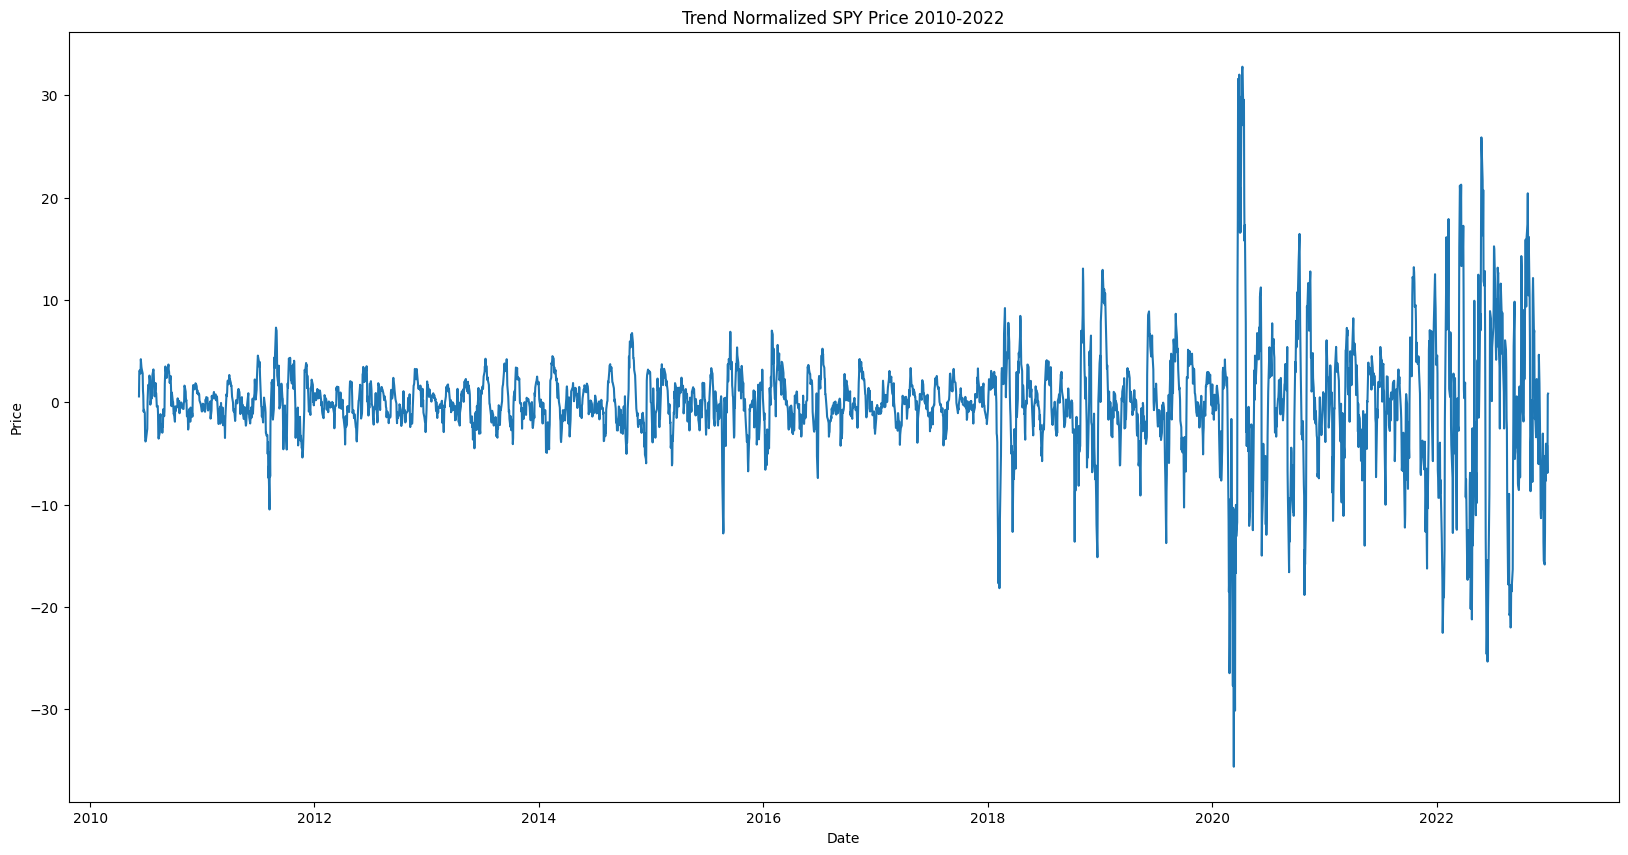

In [58]:
plt.figure(figsize=(20, 10))
plt.title("Trend Normalized SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(tn_prices[["Close"]].iloc[150:, :])

<h1 style="font-size:30px;"> <center> Adding Technical Indicators </center> </h1>

In [59]:
prices_and_indicators = tn_prices.copy()

In [60]:
for i in range(7, 30):
    prices_and_indicators[f"RSI-{i}"] = talib.RSI(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"WILLR-{i}"] = talib.WILLR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"STOCH-{i}"] = talib.STOCH(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        fastk_period=i + 7,
        slowk_period=i - 4,
    )[0]
    prices_and_indicators[f"STOCHF-{i}"] = talib.STOCHF(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        fastk_period=i - 2,
        fastd_period=i - 4,
    )[0]
    prices_and_indicators[f"SMA-{i}"] = talib.SMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"EMA-{i}"] = talib.EMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"WMA-{i}"] = talib.WMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"HMA-{i}"] = HMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"TEMA-{i}"] = talib.TEMA(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"PPO-{i}"] = talib.PPO(
        prices_and_indicators["Close"], fastperiod=i, slowperiod=i + 14
    )
    prices_and_indicators[f"ROC-{i}"] = talib.ROC(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"CMO-{i}"] = talib.CMO(
        prices_and_indicators["Close"], timeperiod=i
    )
    prices_and_indicators[f"MACD-{i}"] = talib.MACD(
        prices_and_indicators["Close"], fastperiod=i, slowperiod=i + 14
    )[0]
    prices_and_indicators[f"MAMA-{i}"] = talib.MAMA(
        prices_and_indicators["Close"], fastlimit=1 / i, slowlimit=1 / (i + 14)
    )[0]
    prices_and_indicators[f"STOCHRSI-{i}"] = talib.STOCHRSI(
        prices_and_indicators["Close"], timeperiod=i
    )[0]
    prices_and_indicators[f"DX-{i}"] = talib.DX(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"ADXR-{i}"] = talib.ADXR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"CCI-{i}"] = talib.CCI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"PLUS_DI-{i}"] = talib.PLUS_DI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"MINUS_DI-{i}"] = talib.MINUS_DI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"ATR-{i}"] = talib.ATR(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        timeperiod=i,
    )
    prices_and_indicators[f"SAR-{i}"] = talib.SAR(
        prices_and_indicators["High"], prices_and_indicators["Low"], maximum=1 / i
    )
    prices_and_indicators[f"PLUS_DM-{i}"] = talib.PLUS_DM(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"AROONOSC-{i}"] = talib.AROONOSC(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"MIDPRICE-{i}"] = talib.MIDPRICE(
        prices_and_indicators["High"], prices_and_indicators["Low"], timeperiod=i
    )
    prices_and_indicators[f"MFI-{i}"] = talib.MFI(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        prices_and_indicators["Volume"],
        timeperiod=i,
    )
    prices_and_indicators[f"ADOSC-{i}"] = talib.ADOSC(
        prices_and_indicators["High"],
        prices_and_indicators["Low"],
        prices_and_indicators["Close"],
        prices_and_indicators["Volume"],
        fastperiod=i - 4,
        slowperiod=i + 3,
    )
    prices_and_indicators[f"BBANDS-{i}"] = talib.BBANDS(
        prices_and_indicators["Close"], timeperiod=i
    )[1]
    prices_and_indicators[f"CMF-{i}"] = CMF(prices_and_indicators, timeperiod=i)
prices_and_indicators["BOP"] = talib.BOP(
    prices_and_indicators["Open"],
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
)
prices_and_indicators["TRANGE"] = talib.TRANGE(
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
)
prices_and_indicators["SAREXT"] = talib.SAREXT(
    prices_and_indicators["High"], prices_and_indicators["Low"]
)
prices_and_indicators["AD"] = talib.AD(
    prices_and_indicators["High"],
    prices_and_indicators["Low"],
    prices_and_indicators["Close"],
    prices_and_indicators["Volume"],
)
prices_and_indicators["OBV"] = talib.OBV(
    prices_and_indicators["Close"], prices_and_indicators["Volume"]
)
prices_and_indicators.dropna(inplace=True)

C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\NEO\anaconda3\envs\cnn-ta\lib\site-packages\ipykernel_launcher.py:137: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

In [61]:
prices_and_indicators

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,ADXR-21,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS

<h1 style="font-size:30px;"> <center> Data Labeling </center> </h1>

In [62]:
prices_and_indicators_with_label = create_labels(prices_and_indicators)
prices_and_indicators_with_label

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS_DI-29,M

In [63]:
prices_and_indicators_with_label["Label"].value_counts()

0    2796
1     216
2     205
Name: Label, dtype: int64

<Figure size 5000x3000 with 0 Axes>

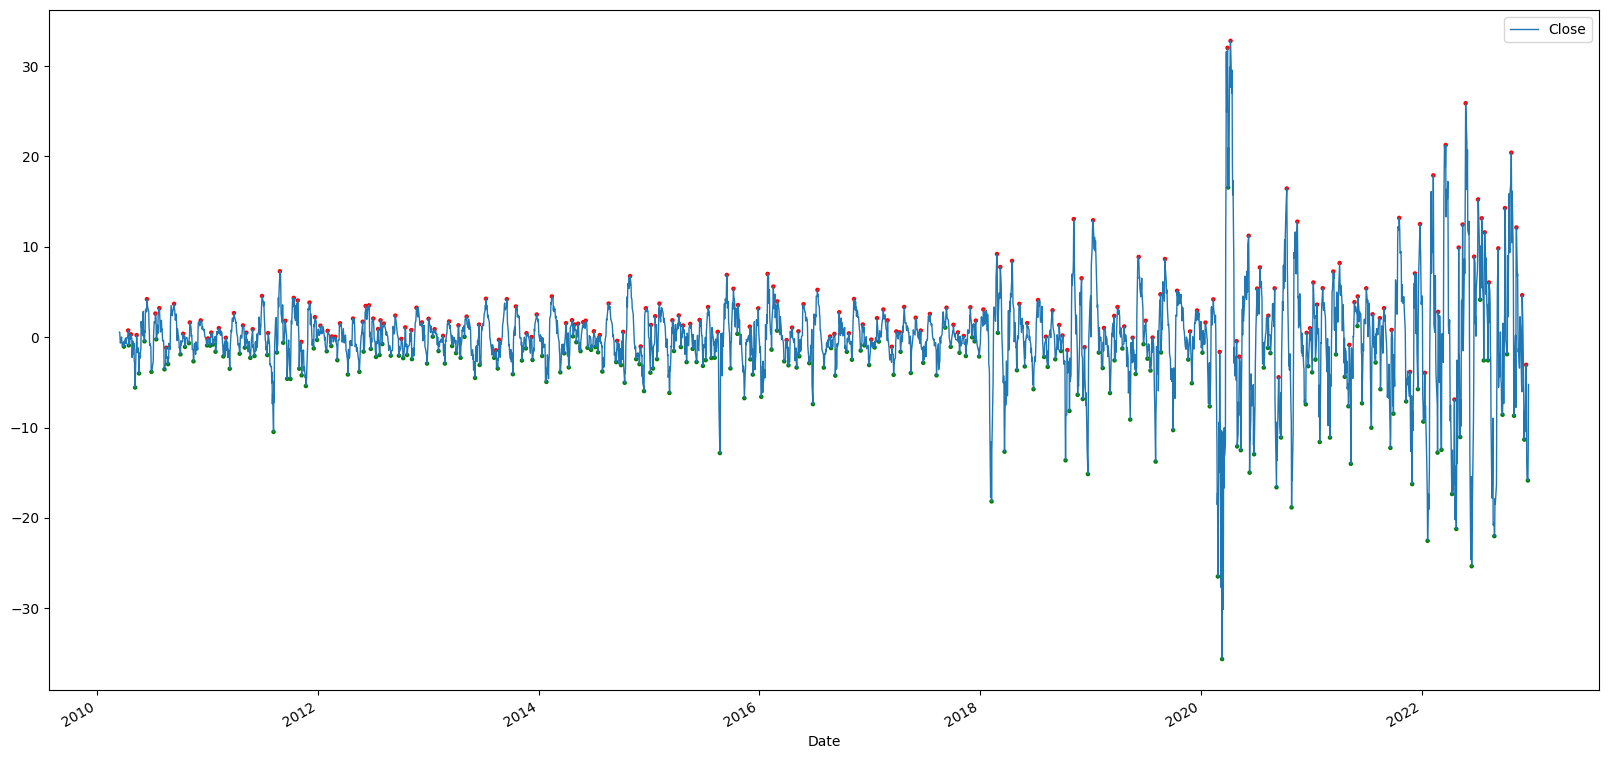

In [64]:
rcParams["figure.figsize"] = 20, 10
plt.figure(figsize=(50, 30))
prices_and_indicators_with_label[["Close"]].plot(
    kind="line", stacked=False, linewidth=1
)
buy_and_sell_preds = prices_and_indicators_with_label.query("Label != 0")
plt.scatter(
    x=buy_and_sell_preds.index,
    y=buy_and_sell_preds.Close,
    s=5,
    c=pltcolor(buy_and_sell_preds.Label),
)
plt.show()

<Figure size 5000x3000 with 0 Axes>

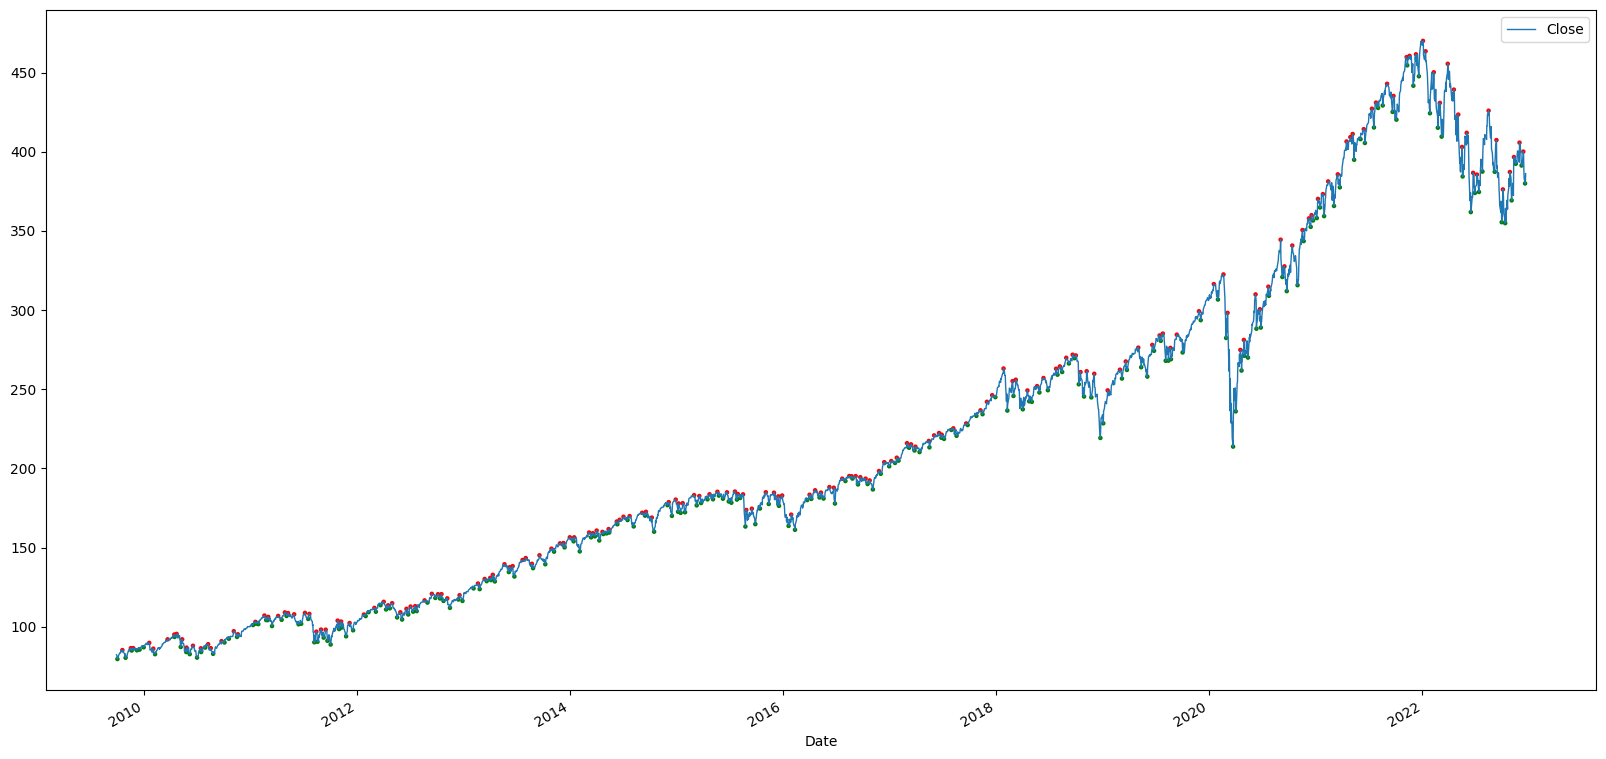

In [65]:
prices_with_label = create_labels(prices)
rcParams["figure.figsize"] = 20, 10
plt.figure(figsize=(50, 30))
prices_with_label[["Close"]].plot(kind="line", stacked=False, linewidth=1)
buy_and_sell_preds = prices_with_label.query("Label != 0")
plt.scatter(
    x=buy_and_sell_preds.index,
    y=buy_and_sell_preds.Close,
    s=5,
    c=pltcolor(buy_and_sell_preds.Label),
)
plt.show()

<h1 style="font-size:30px;"> <center> Creating Train & Test Data </center> </h1>

In [66]:
prices_and_indicators_with_label.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3217 entries, 2010-03-16 00:00:00-04:00 to 2022-12-21 00:00:00-05:00
Columns: 678 entries, Open to Label
dtypes: float64(676), int64(2)
memory usage: 16.7 MB


In [67]:
datas = []

for i in range(5, 13):
    train = prices_and_indicators_with_label.loc[
        (prices_and_indicators_with_label.index >= f"{2010+i-5}")
        & (prices_and_indicators_with_label.index <= f"{2010+i}")
    ]
    test = prices_and_indicators_with_label.loc[
        (prices_and_indicators_with_label.index >= f"{2010+i}")
        & (prices_and_indicators_with_label.index <= f"{2010+i+1}")
    ]
    datas.append([train, test])

<h1 style="font-size:30px;"> <center> Feature Selection </center> </h1>

In [68]:
for i in range(len(datas)):
    selected_feature_count = 30
    select = SelectKBest(score_func=f_classif, k=selected_feature_count)
    fitted = select.fit(datas[i][0].iloc[:, :-1], datas[i][0].iloc[:, -1])
    train_features = fitted.transform(datas[i][0].iloc[:, :-1])
    test_features = fitted.transform(datas[i][1].iloc[:, :-1])

    selected_features_boolean = select.get_support()
    features = list(datas[i][1].columns[:-1])
    selected_features = []
    for j in range(len(features)):
        if selected_features_boolean[j]:
            selected_features.append(features[j])
    train_label = datas[i][0].Label
    test_label = datas[i][1].Label

    datas[i][0] = pd.DataFrame(
        data=train_features.astype("float32"),
        columns=selected_features,
        index=datas[i][0].index,
    )
    datas[i][0]["Label"] = train_label
    datas[i][1] = pd.DataFrame(
        data=test_features.astype("float32"),
        columns=selected_features,
        index=datas[i][1].index,
    )
    datas[i][1]["Label"] = test_label

In [69]:
datas[0][0]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-16 00:00:00-04:00,37.760086,-52.955360,55.304646,-24.479830,39.591175,-58.702793,48.988605,-20.817648,41.267841,-58.702793,47.044640,-17.464321,42.725639,41.297207,-14.548718,41.297207,38.378704,37.570782,36.880276,36.296600,35.788731,35.335510,34.936966,34.592110,34.280930,34.005451,33.772015,33.557140,33.353451,33.161945,0
2010-03-17 00:00:00-04:00,37.574169,-51.517277,68.045654,-24.851662,39.431778,-53.441170,54.733540,-21.136442,41.128689,-59.129250,48.482723,-17.742622,42.602577,46.558830,-14.794847,40.870750,43.800858,42.834583,42.010384,41.314682,40.710331,40.171837,39.698929,39.290115,38.921680,38.595863,38.319950,38.066242,37.825954,37.600243,0
2010-03-18 00:00:00-04:00,28.815746,-75.485596,30.961058,-42.368507,31.711180,-78.285248,30.476717,-36.577641,34.253365,-79.146935,24.514404,-31.493273,36.432915,21.714748,-27.134169,20.853064,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2010-03-19 00:00:00-04:00,21.402641,-82.355812,19.091850,-57.194717,24.677944,-84.927933,17.840012,-50.644112,27.634272,-86.249016,17.644192,-44.731457,30.236225,15.072063,-39.527550,13.750988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2010-03-22 00:00:00-04:00,29.434509,-56.419411,46.038719,-41.130981,31.283409,-56.809734,46.038719,-37.433182,33.145935,-62.088779,43.580589,-33.708130,34.901741,43.190266,-30.196514,37.911221,28.041126,27.258507,26.583864,26.004389,25.496885,25.044243,24.643503,24.291269,23.973351,23.689205,23.440977,23.213181,23.000046,22.801432,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,71.148346,-34.315685,40.716217,42.296692,69.421356,-33.947590,63.216366,38.842705,67.860672,-33.947590,65.684311,35.721340,66.457680,66.052414,32.915367,66.052414,38.980820,41.143524,42.998875,44.603981,46.003201,47.231441,48.316479,49.280643,50.142048,50.915520,51.613281,52.245480,52.820602,53.345787,0
2014-12-26 00:00:00-05:00,72.135704,-34.939671,70.909050,44.271408,70.322174,-32.595440,43.688114,40.644352,68.696289,-32.245796,65.060333,37.392574,67.240875,67.404564,34.481747,67.754204,41.014702,42.024410,42.950047,43.798828,44.577679,45.293102,45.951126,46.557274,47.116570,47.633553,48.579933,49.680401,50.680428,51.592617,0
2014-12-29 00:00:00-05:00,70.688148,-57.836189,50.267368,41.376297,69.128441,-35.885448,63.717255,38.256886,67.680908,-33.477764,42.163811,35.361824,66.357872,64.114548,32.715744,66.522240,6.381757,7.611823,8.731630,9.752848,10.685893,11.540058,12.323611,13.043903,13.707456,14.320054,14.886828,15.412324,15.900573,16.355152,0


In [70]:
datas[0][1]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,42.520817,-77.039192,23.588835,-14.958366,44.853649,-77.039192,23.588835,-10.292698,46.391415,-77.039192,22.960808,-7.217168,47.421970,22.960808,-5.156060,22.960808,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-05 00:00:00-05:00,27.883196,-95.156921,5.039109,-44.233608,31.124861,-95.247093,4.843080,-37.750278,33.593666,-95.247093,4.843080,-32.812668,35.501514,4.752906,-28.996973,4.752906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-06 00:00:00-05:00,24.230738,-89.828735,11.567270,-51.538525,27.512733,-89.828735,10.501947,-44.974533,30.088909,-89.982567,10.171264,-39.822182,32.133095,10.171264,-35.733814,10.017429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2015-01-07 00:00:00-05:00,43.844414,-59.277256,45.624702,-12.311172,44.374352,-60.559528,44.853680,-11.251298,44.875664,-60.559528,40.722744,-10.248670,45.310192,39.440472,-9.379615,39.440472,72.644241,71.864952,71.200714,70.626495,70.123894,69.679176,69.281944,68.924171,68.599609,68.303322,68.031342,67.780464,67.548065,67.331970,0
2015-01-08 00:00:00-05:00,58.889603,-14.809633,96.452919,17.779207,57.927994,-22.655499,86.654762,15.855984,57.213070,-25.090916,85.190369,14.426137,56.644535,77.344498,13.289071,74.909088,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,2
2015-01-09 00:00:00-05:00,50.927486,-33.867588,71.318314,1.854969,50.846012,-34.985172,71.318314,1.692025,50.813679,-40.972912,66.132416,1.627360,50.794132,65.014832,1.588262,59.027088,75.166557,75.074814,74.993240,74.919876,74.853203,74.792076,74.735603,74.683083,74.633980,74.587845,74.544334,74.503166,74.464104,74.426941,0
2015-01-12 00:00:00-05:00,44.741371,-48.080971,51.919029,-10.517261,45.298325,-51.856255,51.919029,-9.403354,45.765804,-52.669846,51.919029,-8.468394,46.151703,48.143745,-7.696591,47.330154,54.977867,54.753300,54.551113,54.367371,54.199024,54.043697,53.899529,53.765034,53.639019,53.520519,53.408730,53.302982,53.202709,53.107430,0
2015-01-13 00:00:00-05:00,43.234322,-52.852657,28.193264,-13.531359,43.950306,-52.852657,47.147343,-12.099388,44.541382,-56.280972,47.147343,-10.917235,45.026974,47.147343,-9.946050,43.719028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-14 00:00:00-05:00,39.825127,-63.247112,32.366753,-20.349751,40.918804,-63.247112,32.366753,-18.162394,41.800720,-63.247112,36.752888,-16.398561,42.518959,36.752888,-14.962081,36.752888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [71]:
for i in range(len(datas)):
    abs_scaler = MaxAbsScaler()
    abs_scaler.fit(datas[i][0])
    scaled_train = abs_scaler.transform(datas[i][0])
    scaled_test = abs_scaler.transform(datas[i][1])
    datas[i][0] = pd.DataFrame(
        data=scaled_train, columns=datas[i][0].columns, index=datas[i][0].index
    )
    datas[i][0]["Label"] = datas[i][0]["Label"] * 2
    datas[i][1] = pd.DataFrame(
        data=scaled_test, columns=datas[i][1].columns, index=datas[i][1].index
    )
    datas[i][1]["Label"] = datas[i][1]["Label"] * 2

In [72]:
datas[0][0]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-03-16 00:00:00-04:00,0.445702,-0.529554,0.553046,-0.350284,0.481727,-0.587028,0.489886,-0.323397,0.516426,-0.587028,0.470446,-0.291943,0.548755,0.412972,-0.259969,0.412972,0.383787,0.375708,0.368803,0.362966,0.357887,0.353355,0.349370,0.345921,0.342809,0.340055,0.337720,0.335571,0.333535,0.331619,0.0
2010-03-17 00:00:00-04:00,0.443508,-0.515173,0.680457,-0.355604,0.479788,-0.534412,0.547335,-0.328349,0.514684,-0.591292,0.484827,-0.296595,0.547174,0.465588,-0.264367,0.408708,0.438009,0.428346,0.420104,0.413147,0.407103,0.401718,0.396989,0.392901,0.389217,0.385959,0.383200,0.380662,0.378260,0.376002,0.0
2010-03-18 00:00:00-04:00,0.340127,-0.754856,0.309611,-0.606254,0.385847,-0.782852,0.304767,-0.568224,0.428647,-0.791469,0.245144,-0.526459,0.467933,0.217147,-0.484856,0.208531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2010-03-19 00:00:00-04:00,0.252627,-0.823558,0.190919,-0.818404,0.300270,-0.849279,0.178400,-0.786743,0.345815,-0.862490,0.176442,-0.747755,0.388345,0.150721,-0.706312,0.137510,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2010-03-22 00:00:00-04:00,0.347431,-0.564194,0.460387,-0.588546,0.380642,-0.568097,0.460387,-0.581515,0.414788,-0.620888,0.435806,-0.563483,0.448267,0.431903,-0.539577,0.379112,0.280411,0.272585,0.265839,0.260044,0.254969,0.250442,0.246435,0.242913,0.239734,0.236892,0.234410,0.232132,0.230000,0.228014,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,0.839801,-0.343157,0.407162,0.605227,0.844687,-0.339476,0.632164,0.603411,0.849209,-0.339476,0.656843,0.597137,0.853561,0.660524,0.588160,0.660524,0.389808,0.411435,0.429989,0.446040,0.460032,0.472314,0.483165,0.492806,0.501420,0.509155,0.516133,0.522455,0.528206,0.533458,0.0
2014-12-26 00:00:00-05:00,0.851455,-0.349397,0.709090,0.633483,0.855647,-0.325954,0.436881,0.631400,0.859665,-0.322458,0.650603,0.625075,0.863621,0.674046,0.616149,0.677542,0.410147,0.420244,0.429500,0.437988,0.445777,0.452931,0.459511,0.465573,0.471166,0.476336,0.485799,0.496804,0.506804,0.515926,0.0
2014-12-29 00:00:00-05:00,0.834369,-0.578362,0.502674,0.592057,0.841123,-0.358854,0.637173,0.594311,0.846959,-0.334778,0.421638,0.591127,0.852280,0.641145,0.584593,0.665222,0.063818,0.076118,0.087316,0.097528,0.106859,0.115401,0.123236,0.130439,0.137075,0.143201,0.148868,0.154123,0.159006,0.163552,0.0


In [73]:
datas[0][1]

,RSI-7,WILLR-7,STOCHF-7,CMO-7,RSI-8,WILLR-8,STOCHF-8,CMO-8,RSI-9,WILLR-9,STOCHF-9,CMO-9,RSI-10,STOCHF-10,CMO-10,STOCHF-11,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,0.501895,-0.770392,0.235888,-0.214040,0.545758,-0.770392,0.235888,-0.159894,0.580542,-0.770392,0.229608,-0.120646,0.609073,0.229608,-0.092133,0.229608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-05 00:00:00-05:00,0.329120,-0.951569,0.050391,-0.632942,0.378713,-0.952471,0.048431,-0.586441,0.420391,-0.952471,0.048431,-0.548514,0.455970,0.047529,-0.518143,0.047529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-06 00:00:00-05:00,0.286008,-0.898287,0.115673,-0.737469,0.334762,-0.898287,0.105019,-0.698668,0.376533,-0.899826,0.101713,-0.665689,0.412707,0.101713,-0.638522,0.100174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
2015-01-07 00:00:00-05:00,0.517519,-0.592773,0.456247,-0.176162,0.539926,-0.605595,0.448537,-0.174786,0.561574,-0.605595,0.407227,-0.171322,0.581950,0.394405,-0.167603,0.394405,0.726442,0.718650,0.712007,0.706265,0.701239,0.696792,0.692819,0.689242,0.685996,0.683033,0.680313,0.677805,0.675481,0.673320,0.0
2015-01-08 00:00:00-05:00,0.695105,-0.148096,0.964529,0.254404,0.704841,-0.226555,0.866548,0.246319,0.715964,-0.250909,0.851904,0.241155,0.727524,0.773445,0.237460,0.749091,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.0
2015-01-09 00:00:00-05:00,0.601124,-0.338676,0.713183,0.026543,0.618671,-0.349852,0.713183,0.026285,0.635882,-0.409729,0.661324,0.027204,0.652384,0.650148,0.028380,0.590271,0.751666,0.750748,0.749932,0.749199,0.748532,0.747921,0.747356,0.746831,0.746340,0.745878,0.745443,0.745032,0.744641,0.744269,0.0
2015-01-12 00:00:00-05:00,0.528106,-0.480810,0.519190,-0.150492,0.551169,-0.518563,0.519190,-0.146079,0.572713,-0.526698,0.519190,-0.141562,0.592758,0.481437,-0.137529,0.473302,0.549779,0.547533,0.545511,0.543674,0.541990,0.540437,0.538995,0.537650,0.536390,0.535205,0.534087,0.533030,0.532027,0.531074,0.0
2015-01-13 00:00:00-05:00,0.510317,-0.528527,0.281933,-0.193621,0.534767,-0.528527,0.471473,-0.187961,0.557391,-0.562810,0.471473,-0.182498,0.578312,0.471473,-0.177725,0.437190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-14 00:00:00-05:00,0.470077,-0.632471,0.323668,-0.291186,0.497881,-0.632471,0.323668,-0.282148,0.523094,-0.632471,0.367529,-0.274127,0.546100,0.367529,-0.267355,0.367529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


<h1 style="font-size:30px;"> <center> Controling Null Values </center> </h1>

In [74]:
total_na_count = 0
for data in datas:
    total_na_count += number_null_and_nan(data[0])
    total_na_count += number_null_and_nan(data[1])
print(f"Total null and nan values = {total_na_count}")

Total null and nan values = 0


<h1 style="font-size:40px;"> <center> MODEL INITIALIZATIONS </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [75]:
def create_model_MLP(trial=None, activation_func="swish", dropout_rate = 0.2, optimizer_algo = "adam"):
    MLP = Sequential()
    MLP.add(Dense(64, input_shape=(30,), activation=activation_func, kernel_initializer=tf.keras.initializers.HeUniform()))
    MLP.add(BatchNormalization())
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(3, activation='softmax'))
    MLP.compile(loss="categorical_crossentropy", optimizer=optimizer_algo, metrics=["accuracy","Precision","Recall","AUC",tfa.metrics.F1Score(num_classes=3, average="macro")])
    return MLP

In [76]:
set_random_seed()

start_time = time.time()
predictions = []
f1_scores = []

for i in range(len(datas)):
    OUTPUT_PATH = "./outputs"
    es = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=20, min_delta=1e-2)
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,f"best_CNN_model-{i+1}.h5"), monitor='val_f1_score', verbose=0, 
                          save_best_only=True, save_weights_only=False, mode='max')
    
    val_split_point = int(0.5*len(datas[i][0]))
    X_train = datas[i][0][:val_split_point].iloc[:, :-1]
    y_train = tf.keras.utils.to_categorical(datas[i][0][:val_split_point].iloc[:, -1], num_classes = 3)
    X_val = datas[i][0][val_split_point:].iloc[:, :-1]
    y_val = tf.keras.utils.to_categorical(datas[i][0][val_split_point:].iloc[:, -1], num_classes = 3)
    X_test = datas[i][1].iloc[:, :-1]
    y_test = datas[i][1].iloc[:, -1]
    
    model = create_model_MLP()
    model.fit(X_train, y_train, batch_size=64, 
                        epochs=1, verbose=0, callbacks=[es, mcp], 
                        validation_data=(X_val, y_val), 
                        class_weight={0:1, 1:10, 2:10})
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=-1)
    predictions.append(y_pred)
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    
print(f"\nAverage f1-macro score: {np.mean(f1_scores)}\n")
minutes = round(int(time.time() - start_time)/60, 2)
print(f"\nCompleted in {minutes} minutes\n")

8/8 [==============================] - 0s 4ms/step

Average f1-macro score: 0.2819080787779


Completed in 0.72 minutes



<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

In [77]:
def create_model_LSTM(trial=None,activation_func="swish", dropout_rate = 0.2, optimizer_algo = "adam"):
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(units=64, return_sequences=True, input_shape=(30, 30), activation=activation_func, kernel_initializer=tf.keras.initializers.GlorotUniform()))
    LSTM_model.add(BatchNormalization())
    LSTM_model.add(LSTM(units=32, return_sequences=True, activation=activation_func))
    LSTM_model.add(BatchNormalization())
    LSTM_model.add(Dropout(dropout_rate))
    LSTM_model.add(LSTM(units=32, return_sequences=False, activation=activation_func))
    LSTM_model.add(BatchNormalization())
    LSTM_model.add(Dropout(dropout_rate))
    LSTM_model.add(Dense(3, activation='softmax'))
    LSTM_model.compile(loss="categorical_crossentropy", optimizer=optimizer_algo, metrics=["accuracy","Precision","Recall","AUC",tfa.metrics.F1Score(num_classes=3, average="macro")])
    return LSTM_model

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

In [78]:
cnn_datas = []

In [79]:
df = datas[0][0].drop(columns=["Label"])
df_matrix_train = pd.DataFrame(
    index=df.iloc[29:].index,
)
df_matrix_train["Image"] = [np.zeros((30, 30))] * df.iloc[29:].shape[0]

for i in range(df_matrix_train.shape[0]):
    matrix = df.iloc[i : i + 30].values.reshape((30, 30, -1))
    df_matrix_train.iloc[i, 0] = matrix
df_matrix_train["Label"] = datas[0][0].iloc[29:, -1]

df = datas[0][1].drop(columns=["Label"])
df_matrix_test = pd.DataFrame(
    index=df.iloc[29:].index,
)
df_matrix_test["Image"] = [np.zeros((30, 30))] * df.iloc[29:].shape[0]

for i in range(df_matrix_test.shape[0]):
    matrix = df.iloc[i : i + 30].values.reshape((30, 30, -1))
    df_matrix_test.iloc[i, 0] = matrix
df_matrix_test["Label"] = datas[0][1].iloc[29:, -1]

In [80]:
df_matrix_test["Label"].value_counts()

0.0    195
1.0     16
2.0     12
Name: Label, dtype: int64

In [81]:
cnn_datas.append((df_matrix_train, df_matrix_test))

In [82]:
def create_model_CNN_2D(trial=None,activation_func="relu", dropout_rate=0.2, optimizer_algo="adam", kernel=3, pooling=3):
    CNN_2D = Sequential()
    CNN_2D.add(Conv2D(filters=64, kernel_size=(kernel, kernel), input_shape=(30,30,1), padding = "same",  activation=activation_func, kernel_initializer=tf.keras.initializers.HeUniform()))
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(MaxPooling2D(pool_size=(pooling, pooling),padding = "same"))
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(Conv2D(filters=64, kernel_size=(kernel, kernel), padding = "same", activation=activation_func))
    CNN_2D.add(BatchNormalization())   
    CNN_2D.add(MaxPooling2D(pool_size=(pooling, pooling),padding = "same"))  
    CNN_2D.add(BatchNormalization())
    CNN_2D.add(Dropout(dropout_rate))
    CNN_2D.add(Flatten())
    CNN_2D.add(Dense(32, activation=activation_func))
    CNN_2D.add(Dropout(dropout_rate))
    CNN_2D.add(Dense(3, activation='softmax'))
    CNN_2D.compile(loss="categorical_crossentropy", optimizer=optimizer_algo, metrics=["accuracy","Precision","Recall","AUC",tfa.metrics.F1Score(num_classes=3, average="macro")])
    return CNN_2D

In [83]:
cnn_datas[0][1]["Label"].value_counts()

0.0    195
1.0     16
2.0     12
Name: Label, dtype: int64

In [84]:
cnn_datas[i][1].iloc[i,1]

IndexError: list index out of range

In [85]:
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

for i in range(len(cnn_datas)):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for j in range(cnn_datas[i][0].shape[0]):
        X_train.append(cnn_datas[i][0].iloc[j,0])
        y_train.append(tf.keras.utils.to_categorical(cnn_datas[i][0].iloc[j,1], num_classes = 3))
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_train_list.append(X_train) 
    y_train_list.append(y_train) 
    
    for j in range(cnn_datas[i][1].shape[0]):
        X_test.append(cnn_datas[i][1].iloc[j,0])
        y_test.append(cnn_datas[i][1].iloc[j,1])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, newshape = (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
    X_test_list.append(X_test) 
    y_test_list.append(y_test) 

In [86]:
set_random_seed()

start_time = time.time()
predictions = []
f1_scores = []

for i in range(len(cnn_datas)):
    OUTPUT_PATH = "./outputs"
    es = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=20, min_delta=1e-2)
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,f"best_CNN_model-{i+1}.h5"), monitor='val_f1_score', verbose=0, 
                          save_best_only=True, save_weights_only=False, mode='max')
    
    #val_split_point = int(0.5*len(cnn_datas[i][0]))
    #X_train = X_train_list[i][:val_split_point]
   # y_train = tf.keras.utils.to_categorical(cnn_datas[i][0][:val_split_point].iloc[:, -1], num_classes = 3)
    #X_val = cnn_datas[i][0][val_split_point:].iloc[:, 0].values
    #y_val = tf.keras.utils.to_categorical(cnn_datas[i][0][val_split_point:].iloc[:, -1], num_classes = 3)
    #X_test = cnn_datas[i][1].iloc[:, 0].values
    #y_test = cnn_datas[i][1].iloc[:, -1]
    
    X_train = X_train_list[i]
    y_train = y_train_list[i]
    X_test = X_test_list[i]
    y_test = y_test_list[i]
    
    model = create_model_LSTM()
    model.fit(X_train, y_train, batch_size=64, 
                        epochs=1, verbose=0, callbacks=[es, mcp], 
                        #validation_data=(X_val, y_val), 
    class_weight={0:1, 1:10, 2:10})
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis=-1)
    predictions.append(y_pred)
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))
    
print(f"\nAverage f1-macro score: {np.mean(f1_scores)}\n")
minutes = round(int(time.time() - start_time)/60, 2)
print(f"\nCompleted in {minutes} minutes\n")

7/7 [==============================] - 1s 24ms/step

Average f1-macro score: 0.3110047846889952


Completed in 0.27 minutes



<h1 style="font-size:40px;"> <center> HYPERPARAMETER TUNING </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

In [ ]:
set_random_seed()
start_time = time.time()

def objective(trial):
    activation_func = trial.suggest_categorical(name="activation_func", choices = ["relu", "selu", "swish"])
    dropout_rate = trial.suggest_categorical("drop_out_rate", [0.1, 0.2, 0.3])
    optimizer_algo = trial.suggest_categorical("optimizer_algorithm", ["adam", "adadelta", "rmsprop"])
    batch = trial.suggest_categorical("batch_size", [32, 64, 256])
    #epoch_num = trial.suggest_categorical("epoch_number", [50, 100, 200])
    lr_max = trial.suggest_categorical("learning_rate_max", [1e-1,1e-2,1e-3,1e-4])

    model = create_model_MLP(trial, activation_func, dropout_rate, optimizer_algo)

    f1_scores = []

    for i in range(len(datas)):
        OUTPUT_PATH = "./outputs"
        es = EarlyStopping(monitor='f1_score', mode='max', verbose=1, patience=20, min_delta=1e-2)
        mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,f"best_CNN_model-{i+1}.h5"), monitor='f1_score', verbose=0, 
                                  save_best_only=True, save_weights_only=False, mode='max')

        val_split_point = int(0.5*len(datas[i][0]))
        X_train = datas[i][0][:val_split_point].iloc[:, :-1]
        y_train = tf.keras.utils.to_categorical(datas[i][0][:val_split_point].iloc[:, -1], num_classes = 3)
        X_val = datas[i][0][val_split_point:].iloc[:, :-1]
        y_val = datas[i][0][val_split_point:].iloc[:, -1]

        model.fit(X_train, y_train, batch_size=batch, 
                                epochs=1, verbose=0, callbacks=[es, mcp], 
                                class_weight={0:1, 1:10, 2:10})
        y_pred = model.predict(X_val)
        y_pred = y_pred.argmax(axis=-1)
        f1_scores.append(f1_score(y_val, y_pred, average='macro'))
    return np.mean(f1_scores)

study = optuna.create_study(study_name="MLP_Bayesian_Optimization", direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=5)
trial = study.best_trial

print("\n------------------------------------------")
print('Best F1 Macro: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
minutes = round(int(time.time() - start_time)/60, 2)
print(f"\nCompleted in {minutes} minutes")

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>

<h1 style="font-size:40px;"> <center> FINANCIAL EVALUATION </center> </h1>

<h1 style="font-size:30px;"> <center> MLP </center> </h1>

<h1 style="font-size:30px;"> <center> LSTM </center> </h1>

<h1 style="font-size:30px;"> <center> GRU </center> </h1>

<h1 style="font-size:30px;"> <center> CNN </center> </h1>